<a href="https://colab.research.google.com/github/r42arty/hse/blob/main/mod3/ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center> Практическое домашнее задание 2 </center>

*`credits to ML course by E. Sokolov`*

### Общая информация

Дата выдачи: 23.02.2025

Первый дедлайн: 07:59MSK 22.03.2025

Второй дедлайн: 07:59MSK 24.03.2025

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

**Штраф за каждый день просрочки мягкого дедлайна**: 0.5 баллов. После жесткого дедлайна работы не принимаются.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник.

### Формат сдачи
Задания сдаются через яндекс-форму в чате курса. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Введение

*эта часть - введение в задачу, баллов за нее не предусмотрено - она исключительно, чтобы помочь вам :-)*

Решение любой задачи, связанной с машинным обучением, начинается с разведочного анализа данных. Перед тем, как строить модели, надо понять, сколько у нас данных и какая информация есть о каждом объекте, а также:
* выяснить, нет ли пропусков в данных (т.е. отсутствующих значений признаков у некоторых объектов)
* выяснить, нет ли выбросов (т.е. объектов, которые очень сильно отличаются от большинства, имеют неадекватные значения признаков)
* выяснить, нет ли повторов в данных
* выяснить, нет ли нелогичной информации (например, если мы анализируем данные по кредитам, и видим запись, где кредит выдали пятилетнему ребёнку, то это странно)

И это лишь небольшой список проблем, которые можно выявить. Помимо этого с данными нужно в целом познакомиться, чтобы понять, какие признаки там можно сделать, какие из них будут наиболее полезны.

Попробуем провести такой анализ на реальной задаче предсказания продолжительности поездки на такси в Нью-Йорке:

In [ ]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

train = pd.read_csv('train.csv')
train.head()

Смысл столбцов:

* id - идентификатор поездки
* vendor_id - код провайдера, от которого пришла информация о поездке
* pickup_datetime - время старта поездки
* dropoff_datetime - время окончания поездки
* passenger_count - число пассажиров (вводится водителем)
* pickup_longitude - долгота точки посадки
* pickup_latitude - широта точки посадки
* dropoff_longitude - долгота точки высадки
* dropoff_latitude - долгота точки высадки
* store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
* trip_duration - продолжительность поездки в секундах

Посмотрим внимательно на столбцы из нашей таблицы и попробуем проверить, нет ли там противоречий и проблем. Например, в голову приходят следующие вопросы:
* можно ли считать ID уникальным идентификатором поездки, или же есть записи с одинаковыми ID?
* есть ли где-то пропуски?
* действительно ли столбец store_and_fwd_flag принимает только значения Y и N?

In [ ]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()))))

In [ ]:
train.dtypes

Видно, что pandas отнёс столбцы с датами к общему типу object. Будет лучше привести их к типу datetime, чтобы использовать удобные функции для манипуляций с датами. Заодно сделаем проверку — действительно ли столбец check_trip_duration показывает продолжительность поездки, или же он входит в противоречие со столбцами pickup_datetime и dropoff_datetime.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

In [ ]:
train.head()

Ещё имеет смысл проверить целевую переменную trip_duration. Нет ли там выбросов? Какими по продолжительности бывают поездки? Выглядит ли распределение этой переменной осмысленно?

Когда в каком-то столбце распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не очень информативны. В этом случае может быть полезно нарисовать распределение в логарифмической шкале.

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [ ]:
print("В секундах:", np.exp(5), np.exp(9))
print("В минутах:", np.exp(5) // 60, np.exp(9) // 60)

Кандидатов на выбрасывание не так уж много — например, если взять поездки длиной 10 часа и больше, то их окажется около двух тысяч, и определённо надо выяснять, что это такое.

In [ ]:
train[train.trip_duration >= 10 * 3600]

Попробуем нарисовать, откуда обычно стартуют поездки.

In [ ]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [ ]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Кстати, случайный ли порядок записей в таблице? Это важно понимать, например, для разбиения выборки на обучающую и тестовую части. Если порядок не является случайным, а мы отнесём к обучающей части первую половину таблицы, то есть риск, что данные в обучении и тесте будут иметь разные распределения, а значит, модель сможет хорошо работать только на одной из частей.

In [ ]:
plt.figure(figsize=(15,5))
days_since_min_ride = (train['pickup_datetime'] - train['pickup_datetime'].min()).apply(lambda x: x.total_seconds() // (60*60*24))
plt.plot(days_since_min_ride[::1000], 'o-')
plt.title('Связь номера строки и времени поездки')
plt.xlabel('Номер записи в таблице')
plt.ylabel('Дней с момента ранней поездки')

Вроде бы всё довольно случайно.

Посчитаем какие-нибудь признаки. Скорее всего продолжительность поездки неплохо зависит от расстояния — посчитаем его. Кстати, важно заметить, что само расстояние не может быть признаком, поскольку в тестовой выборке нет информации о пункте назначения. Но мы пока исследуем данные и, может, увидим в расстояниях что-то интересное.

Можно выбрать научный подход и посчитать честное расстояние на сфере между двумя точками. Это называется haversine distance.

Можно решить, что Земля плоская, и считать стандартные расстояния. В этом случае очень неплохо подойдёт манхэттенское расстояние — оно учитывает, что машины всё-таки не летают.



In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Обсудим немного скорость вычислений в pandas. Есть несколько способов применить функцию к каждой строке в таблице. Если вы до этого изучали преимущественно C/C++, то первое, что должно прийти вам в голову, — написать цикл.

In [ ]:
%%timeit

for i in range(100):
    train1[i, 'distance_haversine'] = haversine_array(train1['pickup_latitude'].iloc[i],
                                                      train1['pickup_longitude'].iloc[i],
                                                      train1['dropoff_latitude'].iloc[i],
                                                      train1['dropoff_longitude'].iloc[i])

Обратите внимание, что мы посчитали расстояния всего лишь для первых 100 записей, и это уже было не очень быстро.

Можно воспользоваться функцией apply.

In [ ]:
%%timeit

train1.iloc[:5000, :].apply(lambda x:
                            haversine_array(x['pickup_latitude'],
                                            x['pickup_longitude'],
                                            x['dropoff_latitude'],
                                            x['dropoff_longitude']),
                            axis=1)

За то же самое время мы успеваем обработать уже 5000 записей, а не 100.

Но лучший способ — это векторизовать вычисления. Подробнее об этом мы будем говорить на следующих семинарах.

In [ ]:
%%timeit
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

## Часть 0. Подготовка (1.5 балла)

**Задание 1 (1.5 балла)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

*1.5 балла - за всю эту часть*

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

In [14]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

train = pd.read_csv("train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [15]:
train_set = train.drop("dropoff_datetime", axis=1)
train_set["pickup_datetime"] = pd.to_datetime(train_set["pickup_datetime"])
train_set['date'] = train_set['pickup_datetime'].dt.date

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

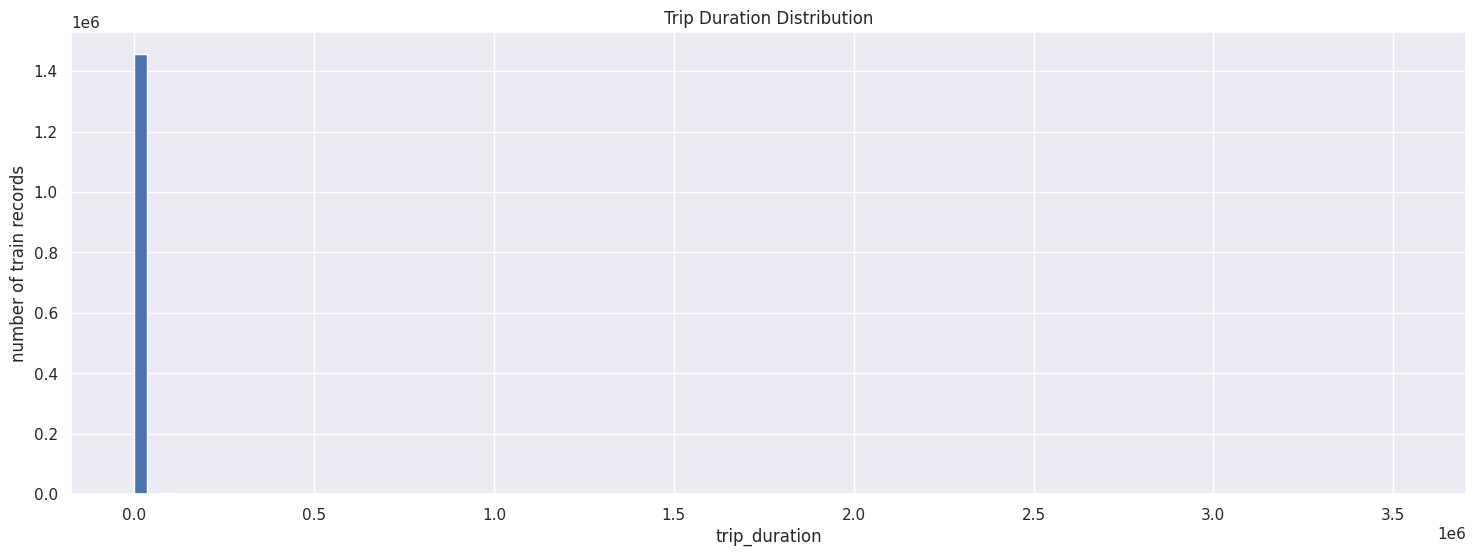

In [16]:
plt.figure(figsize=(18,6))
plt.title("Trip Duration Distribution")

plt.hist(train_set['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')

plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Мы смогли свести задачу оптимизации RMSLE к эквивалентной задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [17]:
train_set['log_trip_duration'] = np.log1p(train_set['trip_duration'].values)

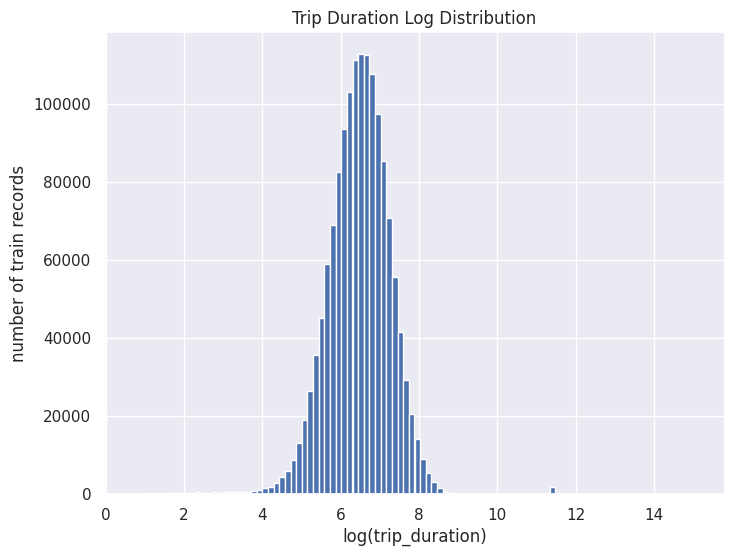

In [18]:
plt.figure(figsize=(8,6))
plt.title("Trip Duration Log Distribution")

plt.hist(train_set['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')

plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [19]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred)**2))

log_trip_duration = train_set["log_trip_duration"].values
rmsle_best_const = rmsle(log_trip_duration, np.full_like(log_trip_duration, np.mean(log_trip_duration)))

print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2.5 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [21]:
train_df, test_df = train_test_split(train_set, test_size=0.3, random_state=42)
train_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,date,log_trip_duration
1011257,id2209155,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,844,2016-05-03,6.739337
178550,id0586605,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,1001,2016-01-01,6.909753
551460,id0467144,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,1048,2016-04-24,6.955593
1434271,id0989010,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,784,2016-01-10,6.665684
1173610,id0580742,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,732,2016-02-25,6.597146


In [22]:
train_df['day_month'] = train_df['pickup_datetime'].dt.strftime('%d-%m')
sorted_pickup_dates = (pd.to_datetime(train_df['day_month'].unique() + '-2000', format='%d-%m-%Y')
                       .sort_values()
                       .strftime('%d-%m'))

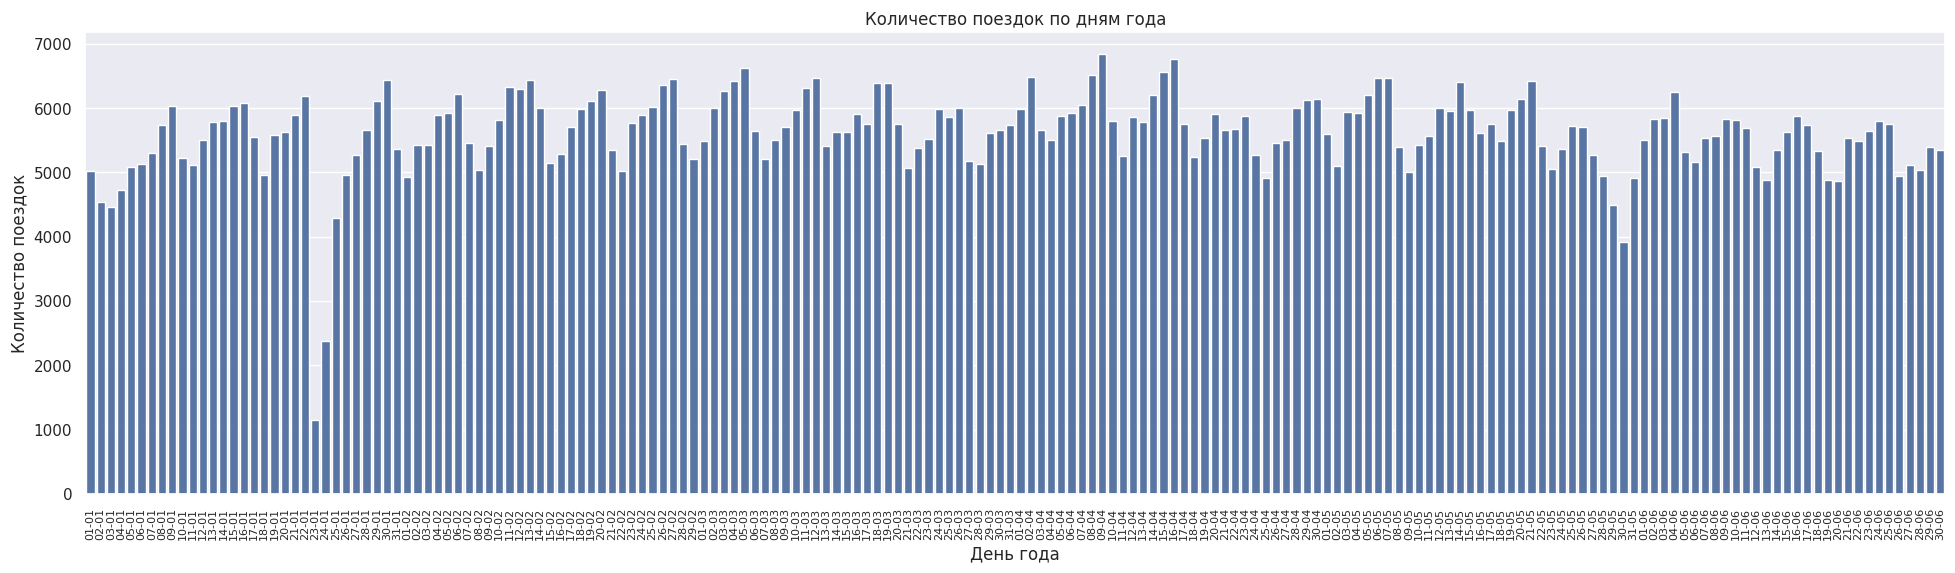

In [24]:
plt.figure(figsize=(24, 6))

sns.countplot(x='day_month', data=train_df, order=sorted_pickup_dates)

plt.title('Количество поездок по дням года')
plt.xlabel('День года')
plt.ylabel('Количество поездок')
plt.xticks(rotation=90, fontsize=8)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

23jan2016 — Сноузилла, сильнейшая снежная буря

30may2016 — Memorial Day, национальный день памяти США, отмечаемый ежегодно в последний понедельник мая. Он посвящён памяти американских военнослужащих, погибших во всех войнах и вооружённых конфликтах, в которых США когда-либо принимали участие.

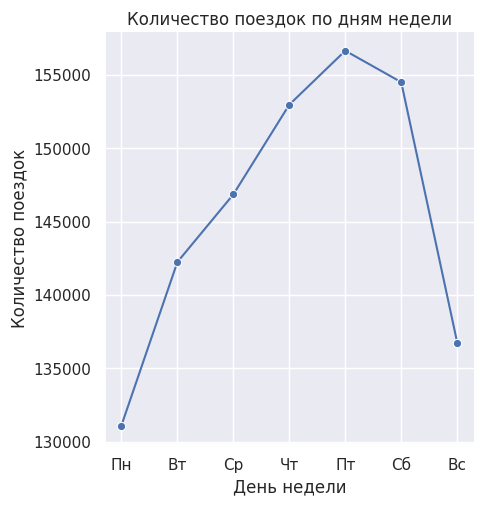

In [25]:
train_df['weekday'] = train_df['pickup_datetime'].dt.weekday
weekday_count = train_df.groupby('weekday')['id'].count().reset_index(name='count')

sns.relplot(x='weekday', y='count', data=weekday_count, kind='line', marker='o')

plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.xlabel("День недели")
plt.ylabel("Количество поездок")
plt.title("Количество поездок по дням недели")
plt.show()

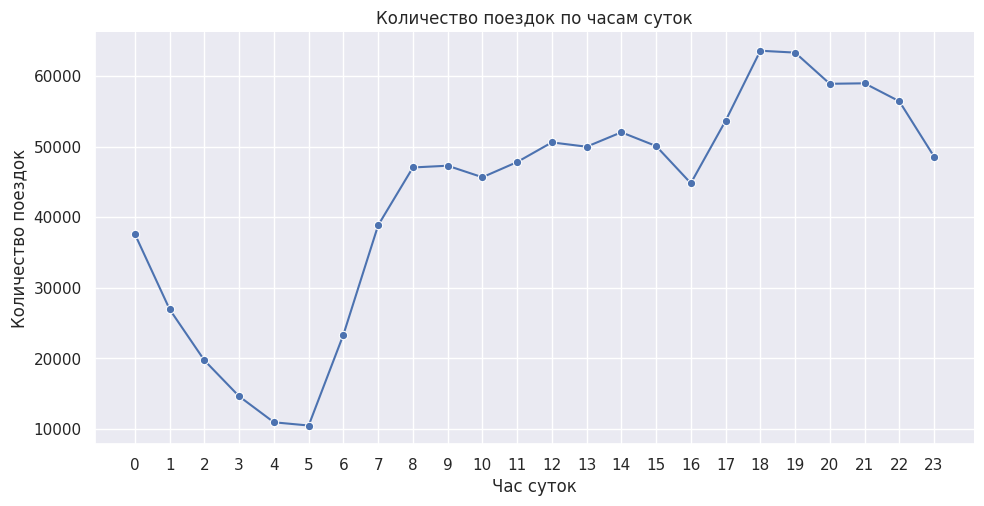

In [26]:
train_df['hour'] = train_df['pickup_datetime'].dt.hour
hour_count = train_df.groupby('hour')['id'].count().reset_index(name='count')

sns.relplot(x='hour', y='count', data=hour_count, kind='line', marker='o', height=5, aspect=2)

plt.title("Количество поездок по часам суток")
plt.xticks(ticks=range(0, 24))
plt.xlabel("Час суток")
plt.ylabel("Количество поездок")
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

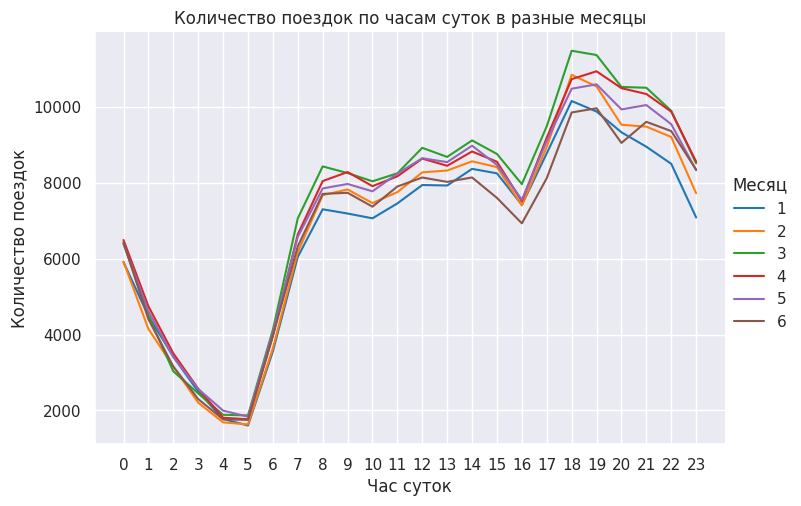

In [27]:
train_df['month'] = train_df['pickup_datetime'].dt.month
month_hour = train_df.groupby(['month', 'hour'])['id'].count().reset_index(name='count')

r = sns.relplot(x='hour', y='count', data=month_hour, kind='line', hue='month', height=5, aspect=1.5, palette='tab10')
r._legend.set_title("Месяц")

plt.title("Количество поездок по часам суток в разные месяцы")
plt.xticks(range(0,24))
plt.xlabel("Час суток")
plt.ylabel("Количество поездок")
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (1 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Задание 6 (1 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine` из одноименной библтотеки. Также можно воспользоваться кодом из введения. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
your_df = ...
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (1 балл)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 8 (0.5 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

*можно использовать данные координат из интернета или воспользоваться `from geopy.geocoders import Nominatim`*

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Задание 9 (0.5 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на всех признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3. Изучаем оставшиеся признаки (1.5 балл)

**Задание 10 (1 балл)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 11 (0.5 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 12 (1.5 балла)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 13 (1.5 балла)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Разбейте _обучающую выборку_ на 5 фолдов кросс-валидации. Подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.